In [ ]:
%load_ext autoreload
%autoreload 2

from mountaintools import client as mt
import os
import pandas as pd
import numpy as np
import spikeextractors as se
from spikeforest_analysis import bandpass_filter
import shutil
import mlprocessors as mlpr
from matplotlib import pyplot as plt

In [ ]:
mt.configRemoteReadonly(collection='spikeforest', share_id='spikeforest.spikeforest2')

In [ ]:
#output_ids=['mearec_neuronexus', 'visapy_mea', 'magland_synth', 'paired', 'mearec_tetrode', 'manual_tetrode', 'bionet']
output_ids=['visapy_mea']

In [ ]:
result_objects=[
    mt.loadObject(
        key=dict(
            name='spikeforest_results'
        ),
        subkey=output_id
    )
    for output_id in output_ids
]
studies=[study for X in result_objects for study in X['studies']]
recordings=[recording for X in result_objects for recording in X['recordings']]
sorting_results=[sorting_result for X in result_objects for sorting_result in X['sorting_results']]

In [ ]:
study_sets_by_study = dict()
for study in studies:
    study_sets_by_study[study['name']] = study['study_set']

In [ ]:
pd.DataFrame(data=studies, columns=['study_set', 'name', 'directory'])

In [ ]:
study_set='visapy_mea'
recordings2 = [dict(study=rec['study'], name=rec['name'], **rec['summary']['computed_info']) for rec in recordings]
recordings2 = [rec for rec in recordings2 if study_sets_by_study[rec['study']]==study_set]
pd.DataFrame(data=recordings2, columns=['study', 'name', 'samplerate', 'num_channels', 'duration_sec'])

In [ ]:
def _get_random_spike_waveforms(*, recording, sorting, unit, max_num=50, channels=None, snippet_len=100):
    st = sorting.getUnitSpikeTrain(unit_id=unit)
    num_events = len(st)
    if num_events > max_num:
        event_indices = np.random.choice(
            range(num_events), size=max_num, replace=False)
    else:
        event_indices = range(num_events)

    spikes = recording.getSnippets(reference_frames=st[event_indices].astype(int), snippet_len=snippet_len,
                                   channel_ids=channels)
    if len(spikes) > 0:
        spikes = np.dstack(tuple(spikes))
    else:
        spikes = np.zeros((recording.getNumChannels(), snippet_len, 0))
    return spikes

def get_channels_in_neighborhood(rx, *, central_channel, max_size):
    geom = [rx.getChannelProperty(channel_id=ch, property_name='location') for ch in rx.getChannelIds()]
    loc_central = rx.getChannelProperty(channel_id=central_channel, property_name='location')
    dists = [np.sqrt(np.sum((np.array(loc_central)-np.array(loc))**2)) for loc in geom]
    inds = np.argsort(dists)
    if len(inds) > max_size:
        inds = inds[0:max_size]
    chan_ids = rx.getChannelIds()
    ret = [chan_ids[ind] for ind in inds]
    return ret

def get_unmatched_times(times1, times2, *, delta):
    times1 = np.array(times1)
    times2 = np.array(times2)
    times_concat = np.concatenate((times1, times2))
    membership = np.concatenate(
        (np.ones(times1.shape) * 1, np.ones(times2.shape) * 2))
    indices = times_concat.argsort()
    times_concat_sorted = times_concat[indices]
    membership_sorted = membership[indices]
    diffs = times_concat_sorted[1:] - times_concat_sorted[:-1]
    unmatched_inds = 1 + \
        np.where((diffs[1:] > delta) & (diffs[:-1] > delta)
                 & (membership_sorted[1:-1] == 1))[0]
    if (diffs[0] > delta) and (membership_sorted[0] == 1):
        unmatched_inds = np.concatenate(([0], unmatched_inds))
    if (diffs[-1] > delta) and (membership_sorted[-1] == 1):
        unmatched_inds = np.concatenate(
            (unmatched_inds, [len(membership_sorted)-1]))
    return times_concat_sorted[unmatched_inds]


def get_unmatched_sorting(sx1, sx2, ids1, ids2):
    ret = se.NumpySortingExtractor()
    for ii in range(len(ids1)):
        id1 = ids1[ii]
        id2 = ids2[ii]
        train1 = sx1.getUnitSpikeTrain(unit_id=id1)
        train2 = sx2.getUnitSpikeTrain(unit_id=id2)
        train = get_unmatched_times(train1, train2, delta=100)
        ret.addUnit(id1, train)
    return ret

In [ ]:
def create_spikespray_object(waveforms, name, channel_ids):
    return dict(
        name=name,
        num_channels=waveforms.shape[0],
        num_timepoints=waveforms.shape[1],
        num_spikes=waveforms.shape[2],
        channel_ids=channel_ids,
        spike_waveforms=[
            dict(
                channels=[
                    dict(
                        channel_id=ch,
                        waveform=waveforms[ii,:,spike_index].tolist()
                    )
                    for ii, ch in enumerate(channel_ids)
                ]
            )
            for spike_index in range(waveforms.shape[2])
        ]
    )

def view_spikespray_object(obj):
    for item in obj:
        M=item['num_channels']
        T=item['num_timepoints']
        L=item['num_spikes']
        X=np.zeros((M,T,L))
        for ll, waveform in enumerate(item['spike_waveforms']):
            for mm,chan in enumerate(waveform['channels']):
                waveform_data = chan['waveform']
                X[mm,:,ll] = waveform_data
        plt.plot(X[0,:,:])
        plt.show()

def create_spikesprays(*, rx, sx_true, sx_sorted, neighborhood_size, num_spikes, unit_id_true, unit_id_sorted):
    rx = bandpass_filter(recording=rx, freq_min=300, freq_max=6000)
    sx_unmatched_true = get_unmatched_sorting(sx_true, sx, [unit_id_true], [unit_id_sorted])
    sx_unmatched_sorted = get_unmatched_sorting(sx, sx_true, [unit_id_sorted], [unit_id_true])
    waveforms0 = _get_random_spike_waveforms(recording=rx, sorting=sx_true, unit=unit_id_true)
    avg=np.mean(waveforms0, axis=2)
    peak_chan = np.argmax(np.max(np.abs(avg),axis=1), axis=0)
    nbhd_channels = get_channels_in_neighborhood(rx, central_channel=peak_chan, max_size=7)
    waveforms1 = _get_random_spike_waveforms(recording=rx, sorting=sx_true, unit=unit_id_true, channels=nbhd_channels)
    if unit_id_sorted in sx_sorted.getUnitIds():
        waveforms2 = _get_random_spike_waveforms(recording=rx, sorting=sx_sorted, unit=unit_id_sorted, channels=nbhd_channels)
    else:
        waveforms2 = np.zeros((waveforms1.shape[0], waveforms1.shape[1], 0))
    if unit_id_true in sx_unmatched_true.getUnitIds():
        waveforms3 = _get_random_spike_waveforms(recording=rx, sorting=sx_unmatched_true, unit=unit_id_true, channels=nbhd_channels)
    else:
        waveforms3 = np.zeros((waveforms1.shape[0], waveforms1.shape[1], 0))
    if unit_id_sorted in sx_unmatched_sorted.getUnitIds():
        waveforms4 = _get_random_spike_waveforms(recording=rx, sorting=sx_unmatched_sorted, unit=unit_id_sorted, channels=nbhd_channels)
    else:
        waveforms4 = np.zeros((waveforms1.shape[0], waveforms1.shape[1], 0))
    
    ret = []
    ret.append(create_spikespray_object(waveforms1, 'true', nbhd_channels))
    ret.append(create_spikespray_object(waveforms2, 'sorted', nbhd_channels))
    ret.append(create_spikespray_object(waveforms3, 'true_missed', nbhd_channels))
    ret.append(create_spikespray_object(waveforms4, 'sorted_false', nbhd_channels))
    return ret

import json
class CreateSpikeSprays(mlpr.Processor):
    NAME = 'CreateSpikeSprays'
    VERSION = '0.1.0'
    
    recording_directory = mlpr.Input(description='Recording directory', optional=False, directory=True)
    firings_true = mlpr.Input(description='True firings -- firings_true.mda', optional=False)
    firings_sorted = mlpr.Input(description='Sorted firings -- firings.mda', optional=False)
    unit_id_true = mlpr.IntegerParameter(description='ID of the true unit')
    unit_id_sorted = mlpr.IntegerParameter(description='ID of the sorted unit')
    neighborhood_size = mlpr.IntegerParameter(description='Max size of the electrode neighborhood', optional=True, default=7)
    num_spikes = mlpr.IntegerParameter(description='Max number of spikes in the spike spray', optional=True, default=20)
    json_out = mlpr.Output(description='Output json object')
    
    def run(self):
        rx = se.MdaRecordingExtractor(dataset_directory=self.recording_directory, download=True)
        sx_true = se.MdaSortingExtractor(firings_file=self.firings_true)
        sx = se.MdaSortingExtractor(firings_file=self.firings_sorted)
        ssobj = create_spikesprays(rx=rx, sx_true=sx_true, sx_sorted=sx, neighborhood_size=self.neighborhood_size, num_spikes=self.num_spikes, unit_id_true=self.unit_id_true, unit_id_sorted=self.unit_id_sorted)
        with open(self.json_out, 'w') as f:
            json.dump(ssobj, f)

In [ ]:
neighborhood_size=7
num_spikes=20
basedir='spikesprays'
if os.path.exists(basedir):
    shutil.rmtree(basedir)
for sr in sorting_results:
    rec=sr['recording']
    study_name=rec['study']
    study_set_name=study_sets_by_study[study_name]
    rec_name=rec['name']
    sorter_name=sr['sorter']['name']
    
    rx = se.MdaRecordingExtractor(dataset_directory=rec['directory'], download=True)
    sx_true = se.MdaSortingExtractor(firings_file=os.path.join(rec['directory'], 'firings_true.mda'))
    sx = se.MdaSortingExtractor(firings_file=mt.realizeFile(path=sr['firings']))
    cwt = mt.loadObject(path=sr['comparison_with_truth']['json'])
    dirname = '{}/{}/{}/{}/{}'.format(basedir, study_set_name, study_name, rec_name, sorter_name)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    
    list0 = list(cwt.values())
    for ii, unit in enumerate(list0):
        print('')
        print('=========================== {}/{}/{} unit {} of {}'.format(study_name, rec_name, sorter_name, ii+1, len(list0)))
        # ssobj = create_spikesprays(rx=rx, sx_true=sx_true, sx_sorted=sx, neighborhood_size=neighborhood_size, num_spikes=num_spikes, unit_id_true=unit['unit_id'], unit_id_sorted=unit['best_unit'])
        path = os.path.join(dirname, '{}.json'.format(unit['unit_id']))
        CreateSpikeSprays.execute(recording_directory=rec['directory'], firings_true=os.path.join(rec['directory'], 'firings_true.mda'), firings_sorted=sr['firings'], unit_id_true=unit['unit_id'], unit_id_sorted=unit['best_unit'], json_out=path)
        ssobj = mt.realizeFile(path=path)
        if ssobj is None:
            raise Exception('Problem creating spikespray object.')
        print('Saved to {}'.format(path))
#         
#         print('Saving to {}'.format(path))
#         mt.saveObject(dest_path=path, object=ssobj)

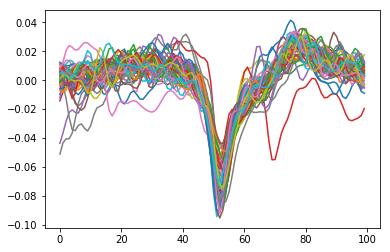

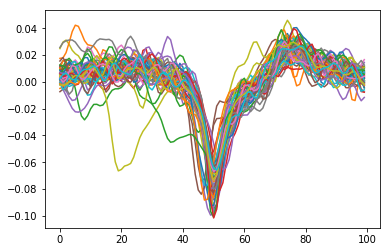

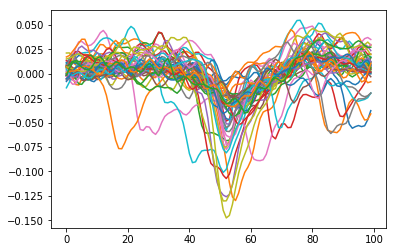

ZeroDivisionError: integer division or modulo by zero

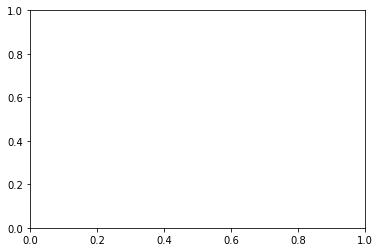

In [13]:
obj=mt.loadObject(path='spikesprays/visapy_mea/visapy_mea/set1/MountainSort4-thr3/1.json')
view_spikespray_object(obj)